<a href="https://www.kaggle.com/code/tauilabdelilah/generate-fashion-minist-with-simple-gan?scriptVersionId=96959078" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt

In [2]:
class Descriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.disc(x)

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.1),
            nn.Linear(512, img_dim),
            nn.Tanh()
        )
    def forward(self, x):
        return self.gen(x)

In [4]:
DEVICE  = 'cuda' if torch.cuda.is_available() else 'cpu'
LR      = 3e-4
Z_DIM   = 64
IMG_DIM = 28*28*1
BS      = 64
EPOCHS  = 100

In [5]:
%%time
disc        = Descriminator(IMG_DIM).to(DEVICE)
gen         = Generator(Z_DIM, IMG_DIM).to(DEVICE) 
fixed_noice = torch.randn((BS, Z_DIM)).to(DEVICE) 
transforms  = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
dataset     = torchvision.datasets.FashionMNIST(root = 'dataset/', transform = transforms, download = True)
loader      = DataLoader(dataset, batch_size=BS, shuffle=True)
opt_disc    = optim.Adam(disc.parameters(), lr=LR)
opt_gen     = optim.Adam(gen.parameters(), lr=LR)
criterion   = nn.BCELoss()

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw

CPU times: user 2.08 s, sys: 917 ms, total: 2.99 s
Wall time: 8.25 s


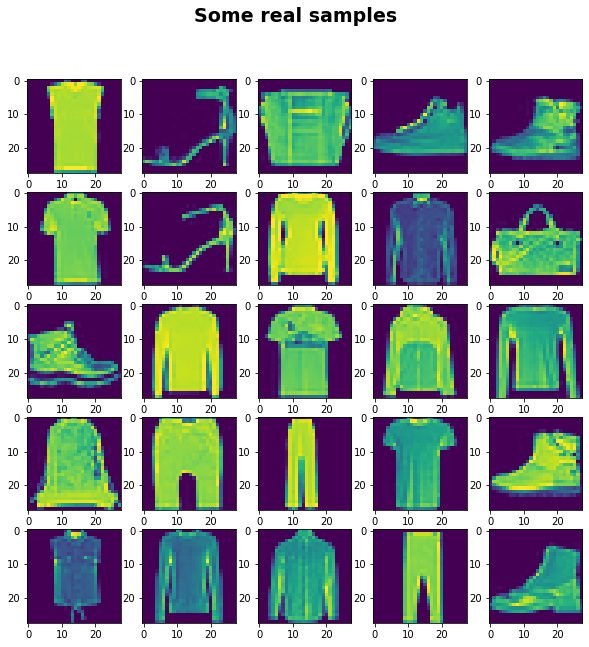

In [6]:
real, y = next(iter(loader))
_, ax = plt.subplots(5,5, figsize=(10,10))
plt.suptitle('Some real samples', fontsize=19, fontweight='bold')

ind = 0 
for k in range(5):
    for kk in range(5):
        ind += 1
        ax[k][kk].imshow(real[ind][0])
        

Epoch [0/100]                       Loss D: 0.1490, loss G: 4.2173
Epoch [1/100]                       Loss D: 0.1900, loss G: 2.5980
Epoch [2/100]                       Loss D: 0.1461, loss G: 4.0338
Epoch [3/100]                       Loss D: 0.4883, loss G: 2.0937
Epoch [4/100]                       Loss D: 0.3916, loss G: 1.7167
Epoch [5/100]                       Loss D: 0.4437, loss G: 1.8496
Epoch [6/100]                       Loss D: 0.6675, loss G: 1.2668
Epoch [7/100]                       Loss D: 0.5239, loss G: 1.5866
Epoch [8/100]                       Loss D: 0.5308, loss G: 1.5458
Epoch [9/100]                       Loss D: 0.5055, loss G: 1.5309
Epoch [10/100]                       Loss D: 0.4163, loss G: 1.8374
Epoch [11/100]                       Loss D: 0.6675, loss G: 1.3969
Epoch [12/100]                       Loss D: 0.6116, loss G: 1.4210
Epoch [13/100]                       Loss D: 0.6122, loss G: 1.3456
Epoch [14/100]                       Loss D: 0.4540, loss 

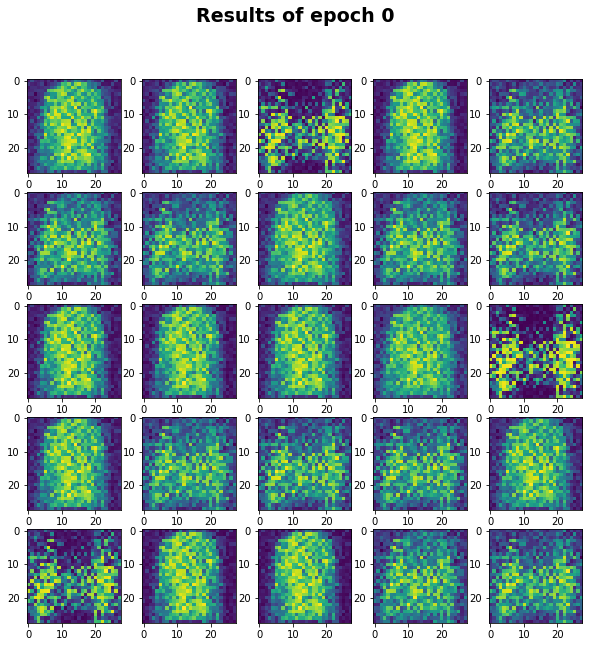

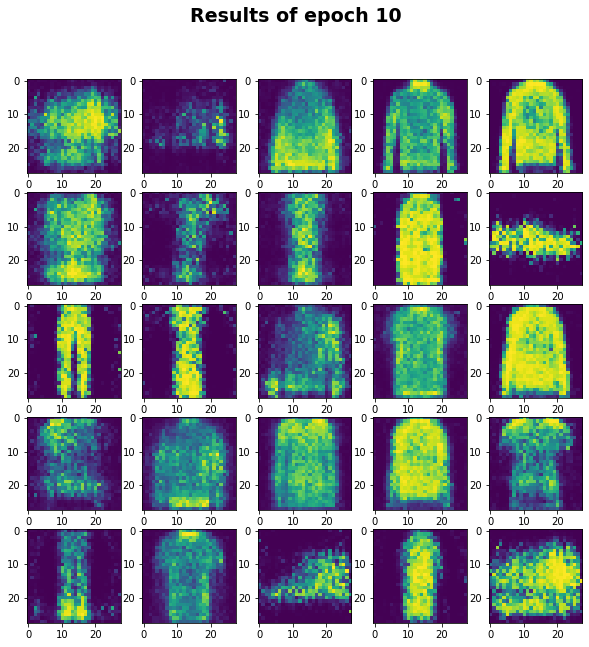

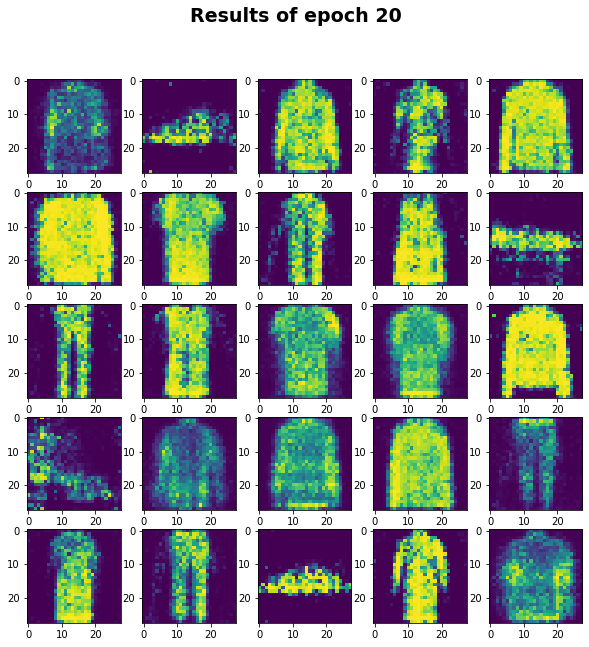

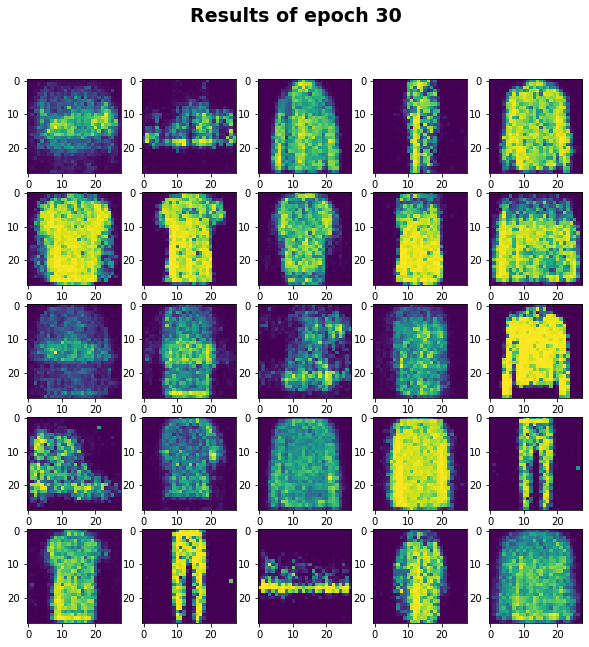

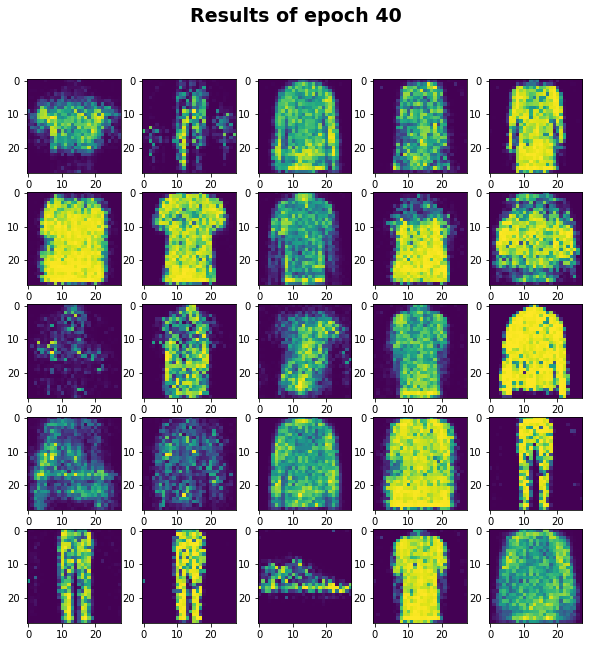

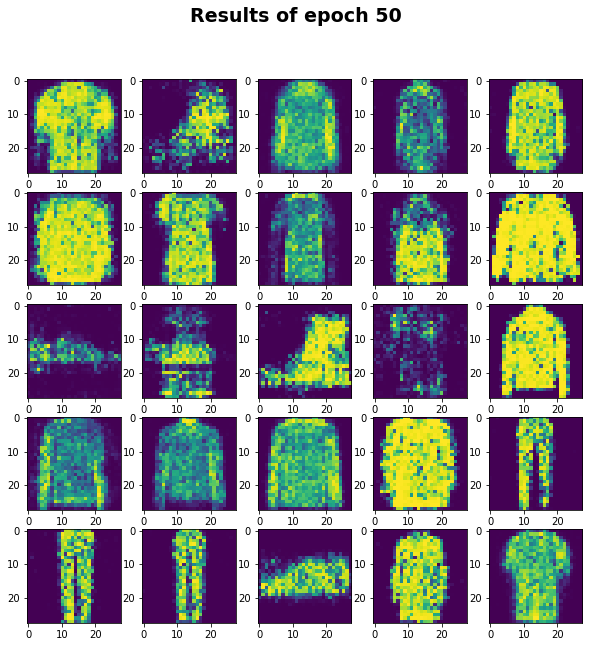

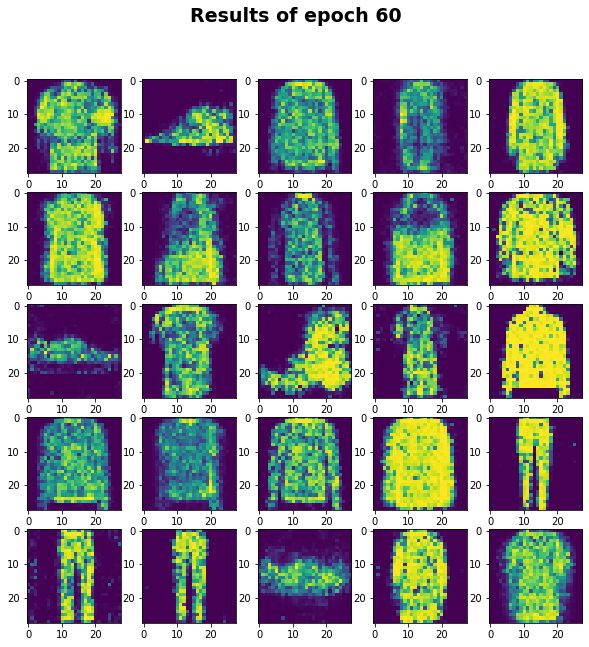

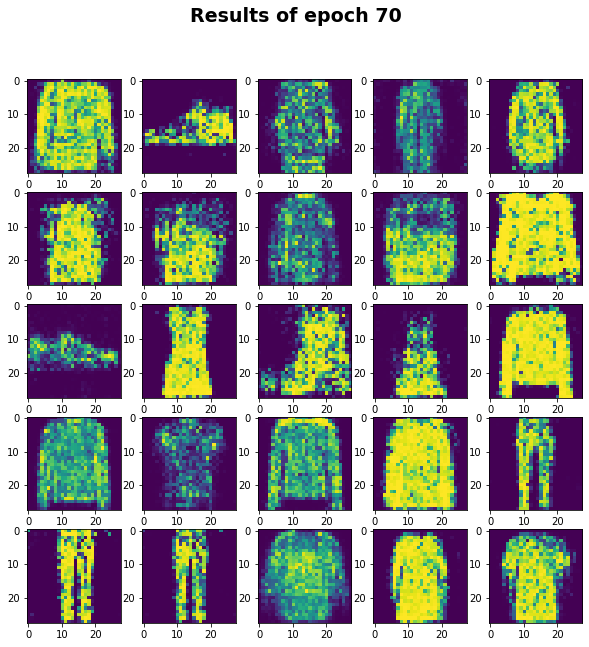

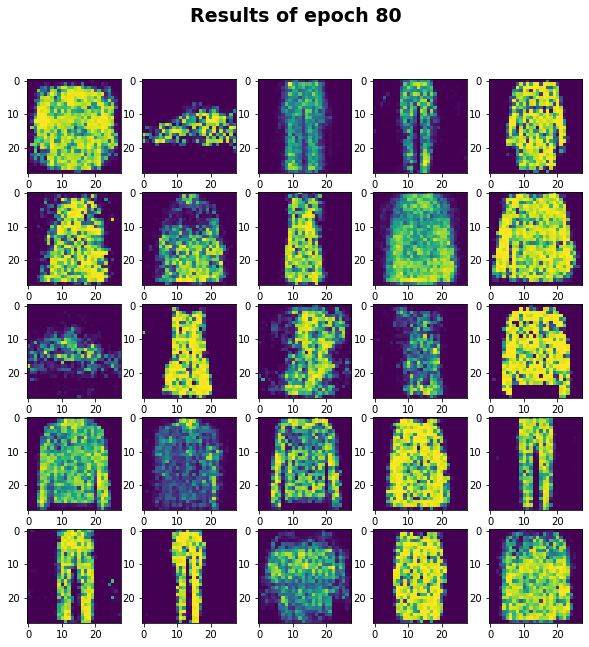

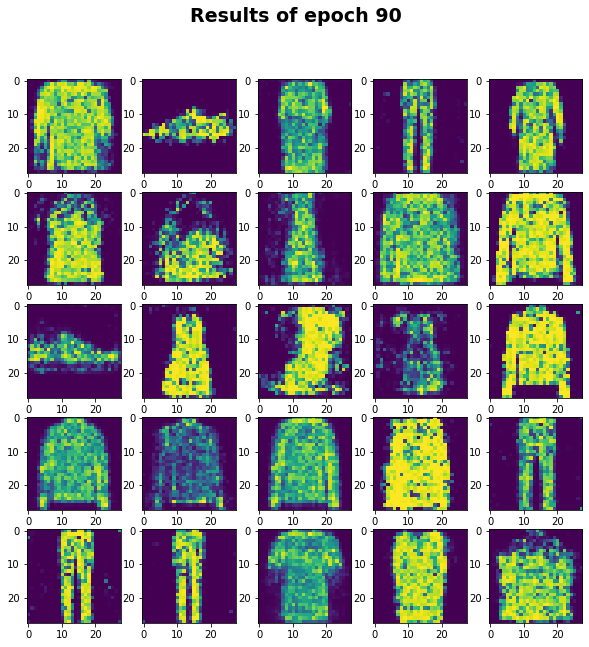

In [7]:
for epoch in range(EPOCHS):
    for batch_idx, (real,_) in enumerate(loader):
        real       = real.view(-1, 784).to(DEVICE)
        batch_size = real.shape[0]
        ######## train Discriminator: max log(D(real)) + log(1-D(G(z)))
        noice     = torch.randn(batch_size, Z_DIM).to(DEVICE)
        fake      = gen(noice)
        disc_real = disc(real).view(-1) #shape [64,1] -> [64] 
        lossD_real= criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake= criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD     = (lossD_real + lossD_fake)/2
        disc.zero_grad()
        lossD.backward(retain_graph=True) # Add retain_graph=True, To save fake in memory 
        opt_disc.step()
        
        ######## train Generator: min log(1-D(G(z))) <==> max log(D(G(z)))
        output = disc(fake).view(-1)
        lossG  = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()
        
            
    print(
                f"Epoch [{epoch}/{EPOCHS}] \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
    )
    
    if epoch %10 == 0:
        with torch.no_grad():
            fake = gen(fixed_noice).reshape(-1, 1, 28, 28).cpu()
        _, ax = plt.subplots(5,5, figsize=(10,10))
        plt.suptitle('Results of epoch '+str(epoch), fontsize=19, fontweight='bold')

        ind = 0 
        for k in range(5):
            for kk in range(5):
                ind += 1
                ax[k][kk].imshow(fake[ind][0])
        